# Appendix: Missing Feature Explorations

The goal is to predict SalePrice

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [32]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [33]:
num_train=np.shape(train)[0]
num_test=np.shape(test)[0]

In [34]:
print(num_train+num_test)

2919


Stack train and test set to be able to apply all transformations to both datasets. In addition, the test set has missing data in more features, thus these need to be handled.

In [4]:
alldata=pd.read_csv('./data/Ames_HousePrice.csv', index_col=0)

In [5]:
#alldata=train.append(test, ignore_index=True)

In [6]:
alldata.dtypes

PID                int64
GrLivArea          int64
SalePrice          int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64


In [7]:
alldata.MSZoning.value_counts()

RL         2008
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64

In [38]:
print(2265+460+139+26+25)

2915


In [39]:
#Apply this after feature transformations to entire data before ML
def split_train_test(alldata,num_train):
    """Splits the data with test stacked underneath train into training and test sets.  
    Must pass number in training set"""
    X_train = alldata.iloc[:num_train, :]
    X_test = alldata.iloc[num_train:, :]
    return X_train,X_test
#Run the line below after transformations and dropping missing values
#X_train,X_test=split_train_test(alldata=alldata,num_train=num_train)


In [40]:
#Filling in missing values (see work below for exploration of  missing features)
#This cell is here for easy reload
alldata['PoolQC']=np.where(alldata.PoolQC.isna(), None, alldata.PoolQC)

alldata['MiscFeature']=np.where(alldata.MiscFeature.isna(), None, alldata.MiscFeature)


alldata['Electrical']=np.where(alldata.Electrical.isna(), 'SBrkr', alldata.Electrical)

alldata['MasVnrType']=np.where(alldata.MasVnrType.isna(), None, alldata.MasVnrType)

alldata['MasVnrArea']=np.where(alldata.MasVnrArea.isna(), 0, alldata.MasVnrArea)




alldata['Alley']=np.where(alldata.Alley.isna(), None, alldata.Alley)

alldata['Fence']=np.where(alldata.Fence.isna(), None, alldata.Fence)

alldata['FireplaceQu']=np.where(alldata.FireplaceQu.isna(), None, alldata.FireplaceQu) #FireplaceQu:fireplace quality



#Replace year garage was built with year house was built. The feature of not having a garage will need to be picked up by categorical garage variables
#Can consider replacing it with 0 to increase the effect of having no garage, but may produce outliers this way
alldata['GarageYrBlt']=np.where(alldata.GarageYrBlt.isna(), alldata.YearBuilt, alldata.GarageYrBlt) #FireplaceQu:fireplace quality

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    alldata[col]=np.where(alldata[col].isna(), None, alldata[col]) 
    

for col in ['GarageArea', 'GarageCars']:
    alldata[col]=np.where(alldata[col].isna(), 0, alldata[col]) 

for col in ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond','BsmtFinType1']:
    alldata[col]=np.where(alldata[col].isna(), None, alldata[col]) 
    
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    alldata[col]=np.where(alldata[col].isna(), 0, alldata[col])    

def fillna_linear_reg(lin_reg, frontage, area):
    area_ = area.loc(frontage.isna())
    pred_frontage = lin_reg.predict(area)
    frontage.loc[nan_mask] = pred_frontage
    
    
#The transformation below is only applied to the training set
from sklearn.linear_model import LinearRegression    
def fillna_linear_reg(X,y,data,mask=None):
    """Fill in the values in one dependent variable based on linear regression off another one"""
    df_=data[mask]
    df_na= data[~mask]
    lin_reg=LinearRegression().fit(df_[[X]],df_[[y]])
    preds=lin_reg.predict(df_na[[X]])
    data.loc[~mask,y]=np.squeeze(preds)
    
fillna_linear_reg('LotArea','LotFrontage',train,mask=train['LotFrontage'].notnull())

#Drop the id column as it is unique for each data point and hence is not useful for prediction
alldata.drop(['Id'], axis=1, inplace=True)


#Some columns only have missing values in the test set.  These are treated below.

#This feature imputation is inspired by https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition
alldata['MSZoning'] = alldata.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

alldata['Utilities']=np.where(alldata.Utilities.isna(), 'AllPub', alldata.Utilities)

alldata['Functional']=np.where(alldata.Functional.isna(), 'Typ', alldata.Functional)

alldata['Exterior1st']=np.where(alldata.Exterior1st.isna(), alldata['Exterior1st'].mode()[0], alldata.Exterior1st)
alldata['Exterior2nd']=np.where(alldata.Exterior2nd.isna(), alldata['Exterior2nd'].mode()[0], alldata.Exterior2nd)

for col in ['BsmtFullBath', 'BsmtHalfBath']:
    alldata[col]=np.where(alldata[col].isna(), 0, alldata[col])  
    
alldata['KitchenQual']=np.where(alldata.KitchenQual.isna(), alldata['KitchenQual'].mode()[0], alldata.KitchenQual)
alldata['SaleType']=np.where(alldata.SaleType.isna(), alldata['SaleType'].mode()[0], alldata.SaleType)



In [8]:
np.sum(alldata.isna()).sort_values(ascending=False)[:50]

PoolQC          2571
MiscFeature     2483
Alley           2412
Fence           2055
FireplaceQu     1241
LotFrontage      462
GarageQual       129
GarageYrBlt      129
GarageFinish     129
GarageCond       129
GarageType       127
BsmtExposure      71
BsmtFinType2      70
BsmtQual          69
BsmtCond          69
BsmtFinType1      69
MasVnrType        14
MasVnrArea        14
BsmtFullBath       2
BsmtHalfBath       2
Electrical         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
TotalBsmtSF        1
GarageCars         1
GarageArea         1
LotConfig          0
RoofMatl           0
Exterior2nd        0
GrLivArea          0
SalePrice          0
MSSubClass         0
MSZoning           0
LotArea            0
Street             0
LotShape           0
LandContour        0
Exterior1st        0
RoofStyle          0
Neighborhood       0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
Utilities          0
HouseStyle         0
BldgType     

In [4]:
# #Filling in missing values (see work below for exploration of  missing features)
# #This cell is here for easy reload
# train['Electrical']=np.where(train.Electrical.isna(), 'SBrkr', train.Electrical)

# train['MasVnrType']=np.where(train.MasVnrType.isna(), None, train.MasVnrType)

# train['MasVnrArea']=np.where(train.MasVnrArea.isna(), 0, train.MasVnrArea)

# train['PoolQC']=np.where(train.PoolQC.isna(), None, train.PoolQC)

# train['MiscFeature']=np.where(train.MiscFeature.isna(), None, train.MiscFeature)


# train['Alley']=np.where(train.Alley.isna(), None, train.Alley)

# train['Fence']=np.where(train.Fence.isna(), None, train.Fence)

# train['FireplaceQu']=np.where(train.FireplaceQu.isna(), None, train.FireplaceQu) #FireplaceQu:fireplace quality



# #Replace year garage was built with year house was built. The feature of not having a garage will need to be picked up by categorical garage variables
# #Can consider replacing it with 0 to increase the effect of having no garage, but may produce outliers this way
# train['GarageYrBlt']=np.where(train.GarageYrBlt.isna(), train.YearBuilt, train.GarageYrBlt) #FireplaceQu:fireplace quality

# for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
#     train[col]=np.where(train[col].isna(), None, train[col]) 
    

# for col in ['GarageArea', 'GarageCars']:
#     train[col]=np.where(train[col].isna(), 0, train[col]) 

# for col in ['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond','BsmtFinType1']:
#     train[col]=np.where(train[col].isna(), None, train[col]) 
    
    
# def fillna_linear_reg(lin_reg, frontage, area):
#     area_ = area.loc(frontage.isna())
#     pred_frontage = lin_reg.predict(area)
#     frontage.loc[nan_mask] = pred_frontage
    
# from sklearn.linear_model import LinearRegression    
# def fillna_linear_reg(X,y,data,mask=None):    
#     df_=data[mask]
#     df_na= data[~mask]
#     lin_reg=LinearRegression().fit(df_[[X]],df_[[y]])
#     preds=lin_reg.predict(df_na[[X]])
#     train.loc[~mask,y]=np.squeeze(preds)
    
# fillna_linear_reg('LotArea','LotFrontage',train,mask=train['LotFrontage'].notnull())


## Check for columns with missing values

In [14]:
np.sum(alldata.isna()).sort_values(ascending=False)[:50]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
BsmtHalfBath       2
BsmtFullBath       2
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
Exterior2nd        1
KitchenQual        1
RoofMatl           0
Utilities          0
MasVnrArea         0
ExterQual          0
Foundation         0
ExterCond          0
RoofStyle          0
LotConfig          0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
BldgType           0
MSZoning           0
LotArea            0
Condition2         0
Street             0
Condition1         0
Neighborhood       0
LotShape           0
LandContour  

In [28]:
np.sum(train.isna()).sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

### Fill in the missing value for *Electrical*

In [115]:
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [88]:
group_=alldata.groupby(['Electrical'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
               count   min   max
Electrical                      
FuseA            188  1879  1960
FuseF             50  1902  1965
FuseP              8  1910  1955
Mix                1  1920  1920
SBrkr           2671  1872  2010

In [87]:
alldata.loc[alldata.Electrical.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500.0


In [90]:
np.sum(alldata.isna()).sort_values(ascending=False)[:50]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
BsmtFullBath       2
BsmtHalfBath       2
GarageCars         1
KitchenQual        1
GarageArea         1
Exterior2nd        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
Exterior1st        1
RoofMatl           0
Street             0
LotShape           0
LotArea            0
MSZoning           0
MSSubClass         0
YearBuilt          0
RoofStyle          0
YearRemodAdd       0
OverallCond        0
OverallQual        0
HouseStyle         0
BldgType           0
Condition2         0
ExterQual          0
Neighborhood       0
LandSlope    

In [75]:
group_=alldata.groupby(['Utilities'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
              count   min   max
Utilities                      
AllPub         2916  1872  2010
NoSeWa            1  1958  1958

In [ ]:
Clearly, there was only on NoSeWa value that occurred in 1958 house, and neither of our houses were built in that year. Thus use AllPub.

In [80]:
alldata.loc[alldata.Utilities.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [79]:
#alldata['Utilities']=np.where(alldata.Utilities.isna(), 'AllPub', alldata.Utilities)

In [128]:
train.loc[train.Electrical.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogPrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500,12.028745


In [89]:
#alldata['Electrical']=np.where(alldata.Electrical.isna(), 'SBrkr', alldata.Electrical)

SBrkr is the only possible value for *Electrical* for *YearBuilt* 2006.

In [82]:
group_=alldata.groupby(['Functional'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
               count   min   max
Functional                      
Maj1              19  1900  2004
Maj2               9  1910  1968
Min1              65  1910  1997
Min2              70  1892  2004
Mod               35  1880  2004
Sev                2  1922  1965
Typ             2717  1872  2010

In [83]:
alldata.loc[alldata.Functional.isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2216,2217,20,RL,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,NaN
2473,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,NaN,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml,NaN


Typ is by far the most common type for Functional, no other info can be deduced from looking at min and max years.

In [23]:
group_=alldata.groupby(['SaleType'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
             count   min   max
SaleType                      
COD             87  1900  2005
CWD             12  1916  2006
Con              5  1940  2009
ConLD           26  1900  2007
ConLI            9  1920  2008
ConLw            8  1900  2007
New            239  1920  2010
Oth              7  1920  1991
WD            2525  1872  2010

In [24]:
alldata['SaleType'].mode()[0]

'WD'

In [31]:
group_=alldata.groupby(['SaleCondition','KitchenQual'])
group_.agg({'SaleCondition':['count', 'min', 'max']})

SaleCondition                  
                                  count      min      max
SaleCondition KitchenQual                                
Abnorml       Ex                     12  Abnorml  Abnorml
              Fa                      6  Abnorml  Abnorml
              Gd                     43  Abnorml  Abnorml
              TA                    129  Abnorml  Abnorml
AdjLand       Fa                      1  AdjLand  AdjLand
              TA                     11  AdjLand  AdjLand
Alloca        Fa                      1   Alloca   Alloca
              Gd                      3   Alloca   Alloca
              TA                     20   Alloca   Alloca
Family        Ex                      2   Family   Family
              Fa                      1   Family   Family
              Gd                     13   Family   Family
              TA                     30   Family   Family
Normal        Ex                    116   Normal   Normal
              Fa                     61   Normal   Normal
              Gd                    932   Normal   Normal
              TA                   1292   Normal   Normal
Partial       Ex                     75  Partial  Partial
              Gd                    160  Partial  Partial
              TA                     10  Partial  Partial

Looks like we should fill it in with the mode, which is much more common for Normal SaleCondition

In [26]:
alldata['KitchenQual'].mode()[0]

'TA'

In [28]:
alldata.loc[alldata.KitchenQual.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1555,50,RL,72.0,10632,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,None,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,None,None,None,0,1,2010,COD,Normal,NaN


In [15]:
group_=alldata.groupby(['Exterior1st'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
                count   min   max
Exterior1st                      
AsbShng            44  1898  1959
AsphShn             2  1915  1965
BrkComm             6  1924  1967
BrkFace            87  1920  1998
CBlock              2  1920  1951
CemntBd           126  1880  2010
HdBoard           442  1880  2003
ImStucc             1  1994  1994
MetalSd           450  1872  2009
Plywood           221  1910  1993
Stone               2  1956  1976
Stucco             43  1880  2008
VinylSd          1025  1875  2010
Wd Sdng           411  1879  1997
WdShing            56  1913  2007

In [22]:
alldata['Exterior1st'].mode()[0]

'VinylSd'

In [24]:
alldata['Exterior2nd'].mode()[0]

'VinylSd'

In [13]:
group_=alldata.groupby(['BsmtFullBath'])
group_.agg({'YearBuilt':['count', 'min', 'max']})

YearBuilt            
                 count   min   max
BsmtFullBath                      
0.0               1705  1872  2010
1.0               1172  1900  2010
2.0                 38  1900  2008
3.0                  2  1987  1987

In [17]:
alldata.loc[alldata.BsmtHalfBath.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2120,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml,NaN
2188,20,RL,123.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,None,None,None,0,7,2008,WD,Normal,NaN


In [25]:
# alldata['Exterior1st']=np.where(alldata.Exterior1st.isna(), alldata['Exterior1st'].mode()[0], alldata.Exterior1st)
# alldata['Exterior2nd']=np.where(alldata.Exterior2nd.isna(), alldata['Exterior2nd'].mode()[0], alldata.Exterior2nd)

In [16]:
alldata.loc[alldata.Exterior1st.isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2151,30,RL,85.0,19550,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,None,1940.0,None,0.0,0.0,None,None,Y,0,39,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN


In [19]:
group_=alldata.groupby(['Exterior1st'])
group_.agg({'Exterior1st':['count', 'min', 'max']})

Exterior1st                  
                  count      min      max
Exterior1st                              
AsbShng              44  AsbShng  AsbShng
AsphShn               2  AsphShn  AsphShn
BrkComm               6  BrkComm  BrkComm
BrkFace              87  BrkFace  BrkFace
CBlock                2   CBlock   CBlock
CemntBd             126  CemntBd  CemntBd
HdBoard             442  HdBoard  HdBoard
ImStucc               1  ImStucc  ImStucc
MetalSd             450  MetalSd  MetalSd
Plywood             221  Plywood  Plywood
Stone                 2    Stone    Stone
Stucco               43   Stucco   Stucco
VinylSd            1025  VinylSd  VinylSd
Wd Sdng             411  Wd Sdng  Wd Sdng
WdShing              56  WdShing  WdShing

In [84]:
#alldata['Functional']=np.where(alldata.Functional.isna(), 'Typ', alldata.Functional)

In [157]:
np.sum(train.isna()).sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
RoofMatl           0
YearRemodAdd       0
RoofStyle          0
dtype: int64

### Fill in the missing value for *MasVnrType* and *MasVnrArea*

In [147]:
# group_=df.groupby(['Exterior1st','Exterior2nd','MasVnrType'])
# group_.agg({'MasVnrType':['count']})

In [240]:
#train['MasVnrType']=np.where(train.MasVnrType.isna(), None, train.MasVnrType)

In [145]:
train.MasVnrArea.value_counts()

0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

If there is no masonry veneer type, we can set the masonry veneer area to 0, which is also the most common value for that variable

In [241]:
#train['MasVnrArea']=np.where(train.MasVnrArea.isna(), 0, train.MasVnrArea)

### Fill in the missing value for *PoolQC*

In [155]:
train.PoolArea.value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [ ]:
There are exactly 1453 missing PoolQC values and 1453 zero PoolAreas.  Thus fill in the PoolQC with None.

In [242]:
#train['PoolQC']=np.where(train.PoolQC.isna(), None, train.PoolQC)

### Fill in the missing value for *MiscFeature*

In [160]:
train.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

MiscFeature is a bonus feature that is generally not present in a house.  Fill it in with None.

In [243]:
#train['MiscFeature']=np.where(train.MiscFeature.isna(), None, train.MiscFeature)

### Fill in the missing value for *Alley*, as NA means there is no valley according to the data description. Same for *Fence* and *FireplaceQu* 

In [244]:
# train['Alley']=np.where(train.Alley.isna(), None, train.Alley)

# train['Fence']=np.where(train.Fence.isna(), None, train.Fence)

# train['FireplaceQu']=np.where(train.FireplaceQu.isna(), None, train.FireplaceQu) #FireplaceQu:fireplace quality

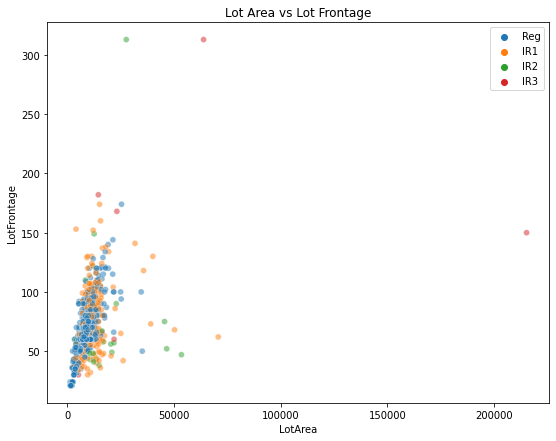

In [171]:
plt.figure(figsize=(9, 7))
#palette=sns.color_palette("Set2")
plot = sns.scatterplot(data = train,x=train["LotArea"], y=train["LotFrontage"],hue=train['LotShape'],alpha=.5)#,palette=palette)

plot.set_title("Lot Area vs Lot Frontage")
plt.legend()
plt.show()

In [246]:
#https://stackoverflow.com/questions/65538171/fillna-with-linear-regression-model-built-from-two-columns-in-dataframe-pandas
#could also consider replacing these with median for the neighborhood+house quality
# def fillna_linear_reg(lin_reg, frontage, area):
#     area_ = area.loc(frontage.isna())
#     pred_frontage = lin_reg.predict(area)
#     frontage.loc[nan_mask] = pred_frontage
    
# from sklearn.linear_model import LinearRegression    
# def fillna_linear_reg(X,y,data,mask=None):    
#     df_=data[mask]
#     df_na= data[~mask]
#     lin_reg=LinearRegression().fit(df_[[X]],df_[[y]])
#     preds=lin_reg.predict(df_na[[X]])
#     train.loc[~mask,y]=np.squeeze(preds)
    
# fillna_linear_reg('LotArea','LotFrontage',train,mask=train['LotFrontage'].notnull())


In [271]:
np.sum(train.isna()).sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
RoofMatl           0
RoofStyle          0
YearRemodAdd       0
MasVnrArea         0
Exterior1st        0
dtype: int64

In [113]:
missing_cats=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageCond', 'GarageType' ,        
'GarageFinish','GarageQual','BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual','MasVnrType','Electrical'] 
missing_nums=['LotFrontage','GarageYrBlt', 'MasVnrArea'] 

In [114]:
train[missing_nums].describe()
#Fill LotFrontage with median
#

,LotFrontage,GarageYrBlt,MasVnrArea
count,1201.000000,1379.000000,1452.000000
mean,70.049958,1978.506164,103.685262
std,24.284752,24.689725,181.066207
min,21.000000,1900.000000,0.000000
25%,59.000000,1961.000000,0.000000
50%,69.000000,1980.000000,0.000000
75%,80.000000,2002.000000,166.000000
max,313.000000,2010.000000,1600.000000


In [43]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [37]:
alldata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [51]:
group_=alldata.groupby(['MSSubClass','MSZoning'])
group_.agg({'MSZoning':['count']})

MSZoning
                       count
MSSubClass MSZoning         
20         C (all)         3
           FV             34
           RH              4
           RL           1016
           RM             20
30         C (all)         8
           RH              2
           RL             61
           RM             67
40         RL              4
           RM              2
45         RH              1
           RL              6
           RM             11
50         C (all)         7
           RH              2
           RL            159
           RM            119
60         FV             43
           RL            529
           RM              3
70         C (all)         4
           RH              3
           RL             57
           RM             63
75         RL              9
           RM             14
80         RL            115
           RM              3
85         RL             47
           RM              1
90         RH              4
           RL             92
           RM             13
120        FV             19
           RH              6
           RL            117
           RM             40
150        RL              1
160        FV             43
           RL             21
           RM             64
180        RM             17
190        C (all)         3
           RH              4
           RL             31
           RM             23

The sale price appears to be skewed to the right

In [79]:
#Add log of SalePrice to improve the predictive power of linear models
train['LogPrice']=np.log1p(train.SalePrice)
#test['LogPrice']=np.log1p(test.SalePrice)

In [74]:
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# From https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
train_num_cols=set(df.select_dtypes(include=np.number).columns.tolist())-set(['SalePrice'])

In [75]:
'SalePrice' in train_num_cols

False

In [62]:
cols=set(df.columns)
train_cat_cols = {col for col in cols if col not in train_num_cols}

Text(0.5, 0.9, 'Numeric Features')

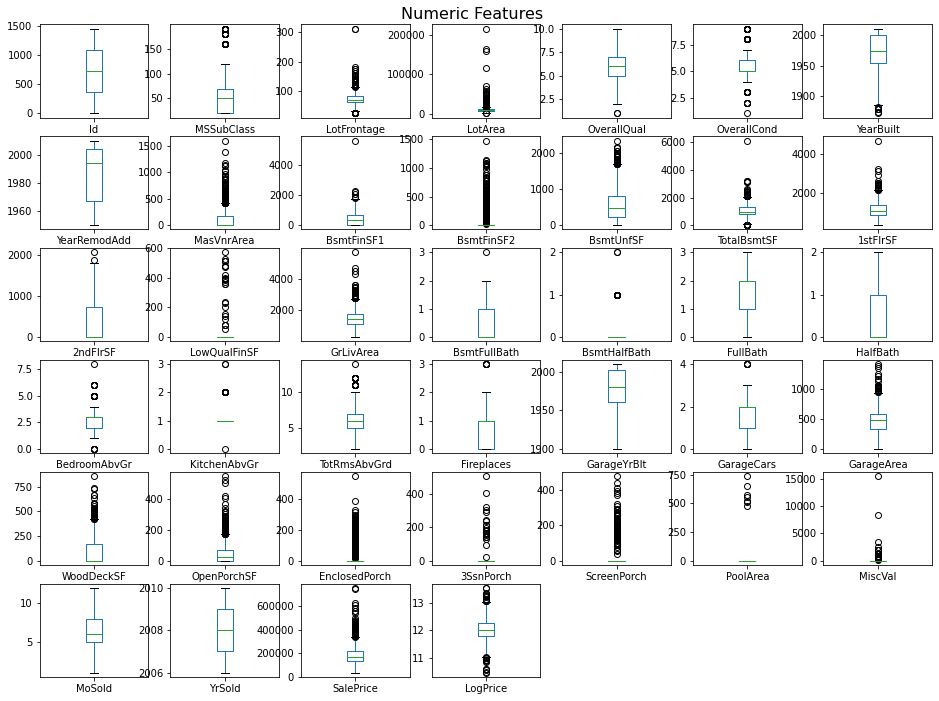

In [85]:
df_ = train.drop(columns= train_cat_cols).select_dtypes(include=np.number)
# subplots
df_.plot(subplots=True, layout=(6,7), kind='box', figsize=(16,12))
plt.suptitle('Numeric Features', fontsize=16, y=0.9)
#plt.savefig('numeric_boxplots.png')

In [58]:
np.sum(X_train.isna()).sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageQual        81
GarageCond        81
GarageFinish      81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
RoofStyle          0
YearRemodAdd       0
RoofMatl           0
ExterQual          0
dtype: int64

In [48]:
model_rf=rf.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   15.9s finished


In [44]:
# # Define error metrics
# def rmsle(y, y_pred):
#     return np.sqrt(mean_squared_error(y, y_pred))

# def cv_rmse(model, X=X):
#     rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=cv))
#     return (rmse)

In [45]:
# train_labels = train['SalePrice'].reset_index(drop=True)
# train_features = train.drop(['SalePrice'], axis=1)
# test_features = test

In [27]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

NameError: name 'cv_rmse' is not defined

In [50]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances['y']

OverallQual      6.155956e-01
GrLivArea        1.223537e-01
TotalBsmtSF      4.780461e-02
GarageCars       2.538266e-02
GarageArea       2.475524e-02
BsmtFinSF1       2.311039e-02
GarageType       1.485280e-02
1stFlrSF         1.427330e-02
YearBuilt        1.186136e-02
LotArea          1.028723e-02
YearRemodAdd     8.557820e-03
Neighborhood     6.324235e-03
Fireplaces       5.445289e-03
LotFrontage      5.190579e-03
OverallCond      4.401009e-03
MSZoning         4.341255e-03
2ndFlrSF         3.721218e-03
OpenPorchSF      3.588323e-03
GarageYrBlt      3.437640e-03
BsmtUnfSF        2.922150e-03
BsmtFinType1     2.798618e-03
LotShape         2.716952e-03
KitchenAbvGr     2.656101e-03
GarageFinish     2.346707e-03
Id               2.302963e-03
WoodDeckSF       2.295000e-03
BsmtQual         1.904872e-03
KitchenQual      1.884237e-03
MSSubClass       1.565276e-03
MasVnrArea       1.538043e-03
MoSold           1.533061e-03
HalfBath         1.403839e-03
FullBath         1.377353e-03
CentralAir

<AxesSubplot:>

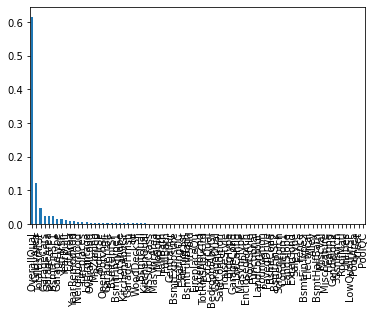

In [54]:
importances['y'].plot(kind='bar')


In [1]:
# top_importances = {}
# focus='Y'
# def DisplayInteraction(feature_1, feature_2, accident_type='Y', xfontsize=None, yfontsize=None):
#     interact_fatals   = crashes.groupby([feature_1, feature_2])[accident_type].mean().reset_index().pivot(index=feature_1, columns=feature_2, values=accident_type)
#     sns.heatmap(interact_fatals, xticklabels=True, yticklabels=True)
#     if xfontsize: plt.xticks(fontsize=xfontsize)
#     if yfontsize: plt.yticks(fontsize=yfontsize)
# DisplayInteraction(top_importances[focus][0], top_importances[focus][1], yfontsize=8)


In [105]:
large_numerics=['GrLivArea','Id','MiscVal','TotalBsmtSF','BsmtFinSF1','1stFlrSF']
small_numerics=['BsmtFullBath','OverallCond','HalfBath','KitchenAbvGr','BsmtHalfBath','FullBath','Fireplaces','GarageCars','OverallQual','MoSold','TotRmsAbvGrd']
['YrSold']
['ScreenPorch']
['LotArea']


['LotArea']

In [250]:
train.YearBuilt.median()

1973.0

Text(0.5, 1.0, 'Year Built')

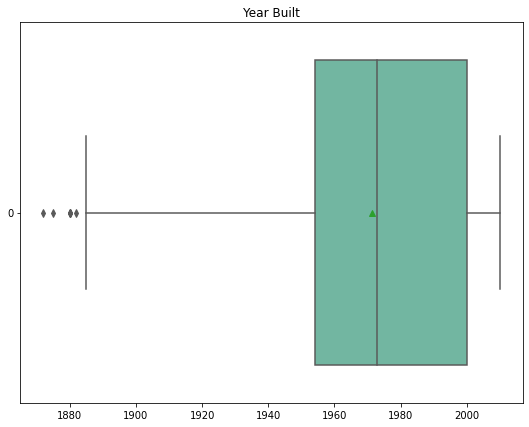

In [249]:
plt.figure(figsize=(9,7))
#for feature in ['MntTotal','MntWines']:
ax = sns.boxplot(data=train['YearBuilt'], orient="h", palette="Set2",
                showmeans=True)
plt.title("Year Built") 
#plt.savefig('./figures/amounts_spent.png')

Text(0.5, 1.0, 'Amounts Spent on Different Categories')

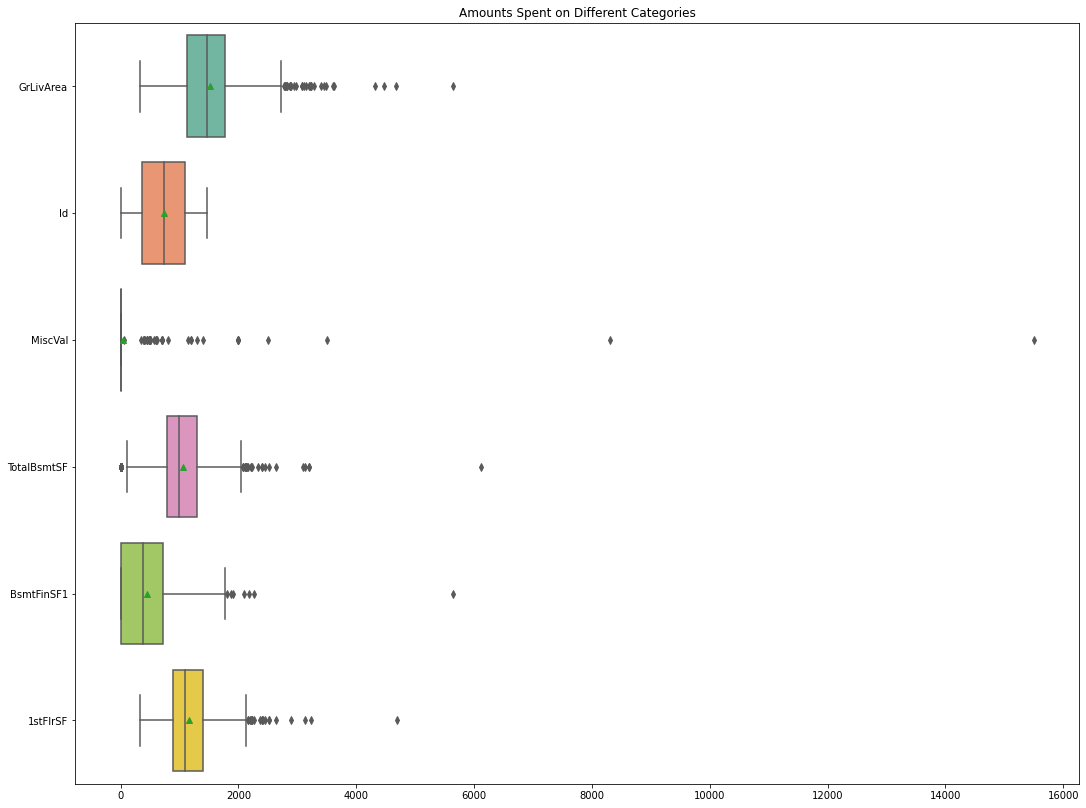

In [106]:
plt.figure(figsize=(18,14))
#for feature in ['MntTotal','MntWines']:
ax = sns.boxplot(data=train[large_numerics], orient="h", palette="Set2",
                showmeans=True)
plt.title("Amounts Spent on Different Categories") 
#plt.savefig('./figures/amounts_spent.png')

Text(0.5, 1.0, 'Amounts Spent on Different Categories')

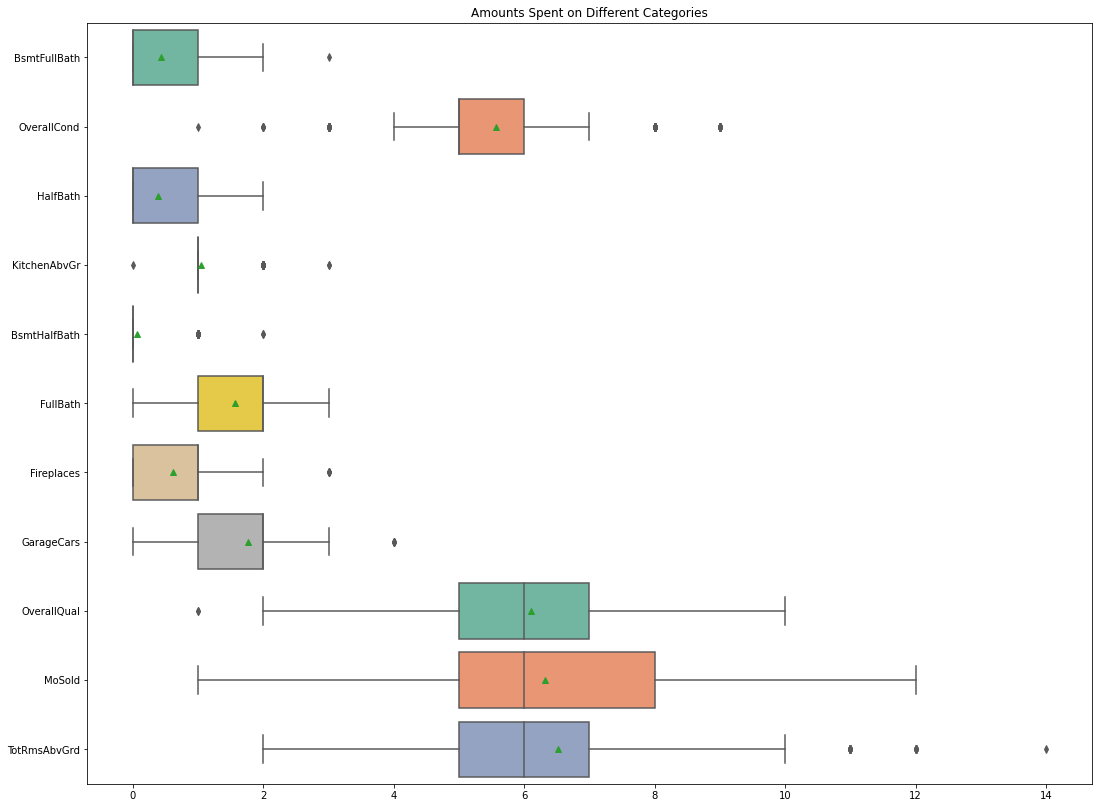

In [107]:
plt.figure(figsize=(18,14))
#for feature in ['MntTotal','MntWines']:
ax = sns.boxplot(data=train[small_numerics], orient="h", palette="Set2",
                showmeans=True)
plt.title("Amounts Spent on Different Categories") 
#plt.savefig('./figures/amounts_spent.png')

Text(0.5, 1.0, 'Amounts Spent on Different Categories')

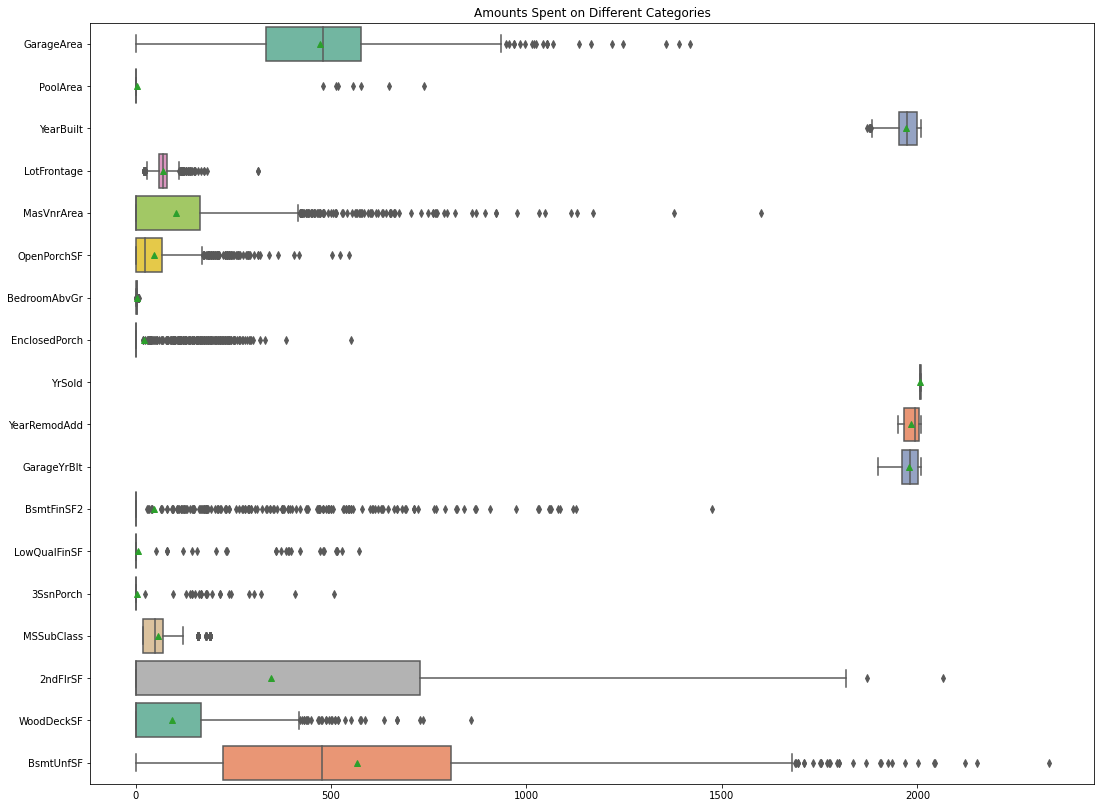

In [100]:
plt.figure(figsize=(18,14))
#for feature in ['MntTotal','MntWines']:
ax = sns.boxplot(data=train[list(train_num_cols-set(large_numerics)-set(small_numerics))], orient="h", palette="Set2",
                showmeans=True)
plt.title("Amounts Spent on Different Categories") 
#plt.savefig('./figures/amounts_spent.png')